# ***Lucrare de practica: determinarea gradului de ocupare al unei camere***
# Rizoiu Alexandra, 336 CA

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("Merged_data_with_weather_and_light.csv")
print(df.columns)

df["naturalLight"] = df["naturalLight"].astype(int)

df["timestamp"] = pd.to_datetime(df["timestamp"])
dict = {'Weekend': 0, 'Weekday': 1}
df = df.replace({"day_of_week": dict})


Index(['timestamp', 'tvoc_ppb', 'temp_c', 'rh_percent', 'light_lux',
       'co2eq_ppm', 'co2eq_base', 'tvoc_base', 'hub', 'home', 'occupied',
       'number', 'day_of_week', 'outside_temp', 'outside_humidity',
       'naturalLight'],
      dtype='object')


/tmp/ipython-input-2-373618580.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"day_of_week": dict})


In [ ]:
def createBalanced(n, home, columns, num_samples=20000, split=True):

  h1_df = df[df['home'] == home].copy()

  #I'll choose 20k samples from each class
  target_samples = num_samples

  def sample_every_n(df, target_samples):
      total_rows = len(df)
      step = max(1, total_rows // target_samples)
      return df.iloc[::step].head(target_samples)

  # Apply function to each class
  balanced_dfs = []
  for class_label in h1_df['number'].unique():
      class_df = h1_df[h1_df['number'] == class_label]
      sampled_df = sample_every_n(class_df, target_samples)
      balanceddfs.append(sampled_df)

  balanced_df = pd.concat(balanced_dfs)
  balanced_df = balanced_df.sort_index().reset_index(drop=True)

  X = balanced_df[columns]
  y = balanced_df['number']

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X.to_numpy())
  X_scaled = pd.DataFrame(X_scaled, columns=columns)


  def create_sequences(X, y, seq_len):
      xs, ys = [], []
      for i in range(len(X) - seq_len):
          xs.append(X[i:i+seq_len])
          ys.append(y[i+seq_len])
      return np.array(xs), np.array(ys)

  X_seq, y_seq = create_sequences(X_scaled, y.values, n)
  X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

  h1_df['time_bin'] = h1_df['timestamp'].dt.floor('15min')
  stats = h1_df.groupby('time_bin')['number'].agg(['mean', 'std']).reset_index()
  h1_df = h1_df.merge(stats, on='time_bin', how='left')

  h1_df['is_edge'] = (h1_df['number'] < (h1_df['mean'] - h1_df['std'])) | \
                    (h1_df['number'] > (h1_df['mean'] + h1_df['std']))

  edge_df = h1_df[h1_df['is_edge']].copy()
  print(edge_df.size)
  edge_df = edge_df.dropna(subset=columns).reset_index()
  edge_df = edge_df.sample(n=len(X_val), replace=True, random_state=42).reset_index(drop=True)


  all_scaled = scaler.transform(h1_df[columns].to_numpy())
  h1_df_scaled = h1_df.copy()
  h1_df_scaled[columns] = all_scaled

  # Create edge sequences: use n previous steps ending at each edge index
  X_val_edge, y_val_edge = [], []
  for idx in edge_df['index']:
      if idx >= n:
          seq = h1_df_scaled.loc[idx - n:idx - 1, columns].values
          X_val_edge.append(seq)
          y_val_edge.append(h1_df.loc[idx, 'number'])

  X_val_edge = np.array(X_val_edge)
  print(X_val_edge.size)
  y_val_edge = np.array(y_val_edge)
  if(split):
    return X_train, X_val, y_train, y_val, X_val_edge, y_val_edge
  else:
    return X_seq, y_seq, X_val_edge, y_val_edge

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

home = "H1"
sensor_cols = ['tvoc_ppb', 'temp_c', 'rh_percent', 'light_lux',
       'co2eq_ppm', 'co2eq_base', 'tvoc_base','day_of_week', 'outside_temp', 'outside_humidity','naturalLight']
h1_df = df[df['home'] == home].copy()

# Create 15-min time bins
h1_df['time_bin'] = h1_df['timestamp'].dt.floor('15min')

# Calculate mean and std occupancy per time bin
stats = h1_df.groupby('time_bin')['number'].agg(['mean', 'std']).reset_index()

# Merge stats back to original dataframe
h1_df = h1_df.merge(stats, on='time_bin', how='left')

# Define edge cases: occupancy outside mean ± std (68% rule)
h1_df['is_edge'] = ((h1_df['number'] < (h1_df['mean'] - h1_df['std'])) |
                    (h1_df['number'] > (h1_df['mean'] + h1_df['std']))).astype(int)

# Drop rows with missing sensor data or missing edge labels
h1_df = h1_df.dropna(subset=sensor_cols + ['is_edge'])

# Prepare features and labels
X = h1_df[sensor_cols].values
y = h1_df['is_edge'].values

print("Original rows:", len(df))
print("Filtered home rows:", len(h1_df))
print("Rows after dropna:", len(h1_df.dropna(subset=sensor_cols + ['is_edge'])))


scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.reshape(len(X_train), -1), y_train)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test.reshape(len(X_test), -1))

print(classification_report(y_test, y_pred))


Original rows: 956005
Filtered home rows: 918922
Rows after dropna: 918922


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:39:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2120
           1       0.75      0.77      0.76      2120

    accuracy                           0.76      4240
   macro avg       0.76      0.76      0.76      4240
weighted avg       0.76      0.76      0.76      4240



===============Small===============
{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 5}
Accuracy: 0.9612461246124613

Classificati

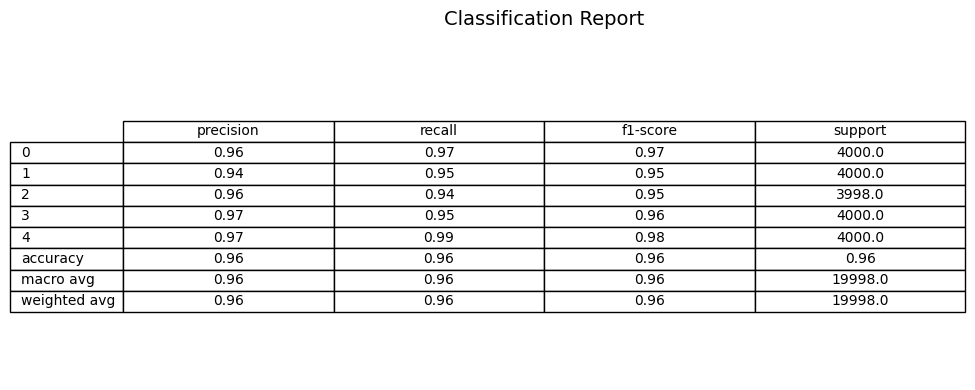

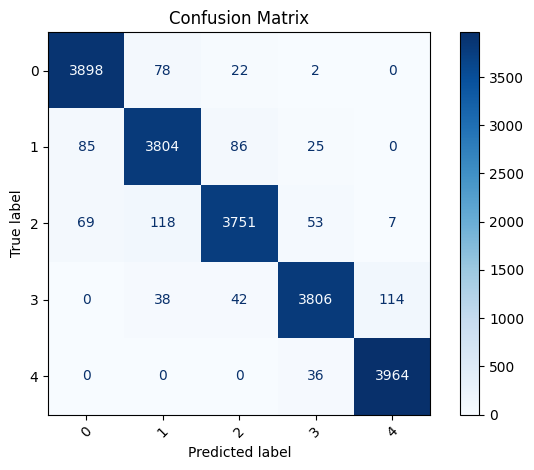

Accuracy: 0.3825882588258826

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.42      0.36      3183
           1       0.37      0.38      0.37      6740
           2       0.44      0.30      0.36      6013
           3       0.20      0.26      0.23      2105
           4       0.73      0.70      0.72      1957

    accuracy                           0.38     19998
   macro avg       0.41      0.41      0.41     19998
weighted avg       0.40      0.38      0.39     19998



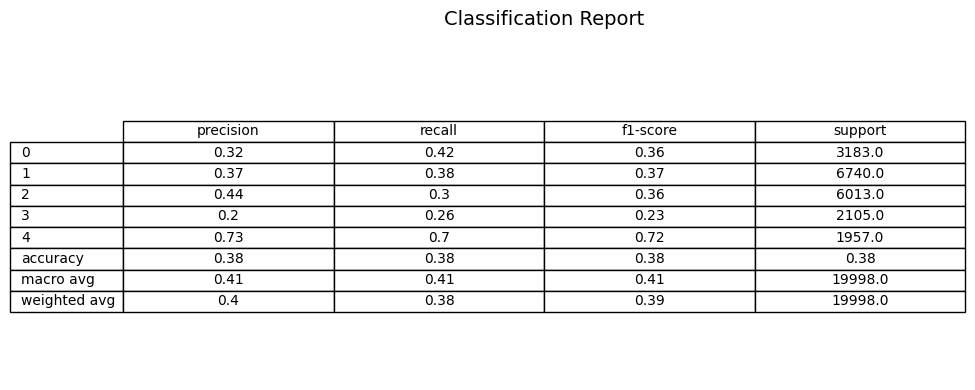

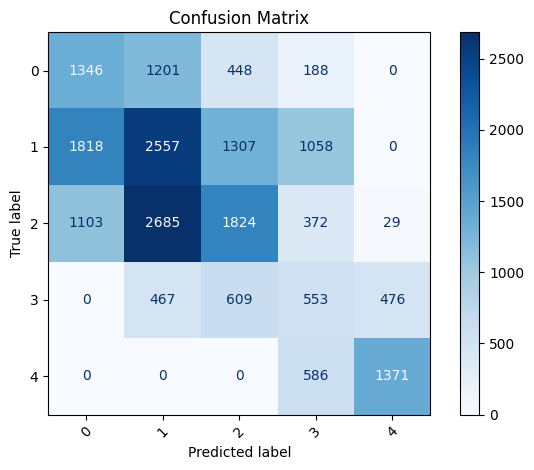

In [ ]:
#Now I will test XGBoost with 3, 5 and 7 input traits
import seaborn as sns


small = ['day_of_week', 'outside_humidity', 'outside_temp']
small_plus = ['day_of_week', 'outside_humidity', 'outside_temp', 'rh_percent']

medium = ['day_of_week', 'outside_humidity', 'outside_temp', 'naturalLight', 'rh_percent']
big = ['day_of_week', 'outside_humidity', 'outside_temp', 'naturalLight', 'rh_percent', 'co2eq_ppm', 'light_lux']
original_small = ['rh_percent', 'co2eq_ppm', 'light_lux']
original_medium = ['rh_percent', 'co2eq_ppm', 'light_lux', 'temp_c', 'co2eq_base']
original_big = ['rh_percent', 'co2eq_ppm', 'light_lux', 'temp_c', 'co2eq_base', 'tvoc_ppb', 'tvoc_base']
# X_train, X_val, y_train, y_val, X_val_edge, y_val_edge = createBalanced(10, 'H1', small)


def evaluate_model(columns):
  #Generate the dataset
  # X_train, X_val, y_train, y_val, X_val_edge, y_val_edge = createBalanced(10, 'H1', columns)

  X_train_flat = X_train.reshape(X_train.shape[0], -1)
  X_val_flat = X_val.reshape(X_val.shape[0], -1)
  X_val_edge_flat = X_val_edge.reshape(X_val_edge.shape[0], -1)


  # Initialize model
  model = xgb.XGBClassifier(
      objective="multi:softmax",
      num_class=5,
      eval_metric="mlogloss",
      device= "cuda"
  )
  print(model.get_params())

  model.fit(X_train_flat, y_train)
  y_pred = model.predict(X_val_flat)
  y_pred_edge = model.predict(X_val_edge_flat)

  # Evaluate
  print("Accuracy:", accuracy_score(y_val, y_pred))
  print("\nClassification Report:\n", classification_report(y_val, y_pred))
  report_dict = classification_report(y_val, y_pred, output_dict=True)
  report_df = pd.DataFrame(report_dict).transpose().round(2)

  fig, ax = plt.subplots(figsize=(10, len(report_df) * 0.5))  # Adjust height based on rows

  ax.axis('off')
  ax.axis('tight')

  # Create the table
  table = ax.table(cellText=report_df.values,
                   colLabels=report_df.columns,
                   rowLabels=report_df.index,
                   loc='center',
                   cellLoc='center')

  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table.scale(1.2, 1.2)

  plt.title("Classification Report", fontsize=14, pad=20)

  plt.tight_layout()
  plt.savefig("classification_report_Normal.png", dpi=300, bbox_inches='tight')

  cm = confusion_matrix(y_val, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
  disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.savefig("XGBmatNormal.jpg")
  plt.show()


  print("Accuracy:", accuracy_score(y_val_edge, y_pred_edge))
  print("\nClassification Report:\n", classification_report(y_val_edge, y_pred_edge))
  report_dict = classification_report(y_val_edge, y_pred_edge, output_dict=True)
  report_df = pd.DataFrame(report_dict).transpose().round(2)

  fig, ax = plt.subplots(figsize=(10, len(report_df) * 0.5))  # Adjust height based on rows

  ax.axis('off')
  ax.axis('tight')

  table = ax.table(cellText=report_df.values,
                   colLabels=report_df.columns,
                   rowLabels=report_df.index,
                   loc='center',
                   cellLoc='center')

  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table.scale(1.2, 1.2)

  plt.title("Classification Report", fontsize=14, pad=20)

  plt.tight_layout()
  plt.savefig("classification_report_edge.png", dpi=300, bbox_inches='tight')

  cm = confusion_matrix(y_val_edge, y_pred_edge)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
  disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.savefig("XGBmatEdge.jpg")
  plt.show()

  return model


print("===============Small===============")
model = evaluate_model(small)

===============Small===============
211960
599940
Epoch 1 - Training Loss: 1.0915
Epoch 2 - Training Loss: 0.7777
Epoch 3 - Training Loss: 0.6630
Epoch 4 - Training Loss: 0.5776
Epoch 5 - Training Loss: 0.5124

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.79      4000
           1       0.78      0.79      0.79      4000
           2       0.75      0.73      0.74      3998
           3       0.75      0.78      0.76      4000
           4       0.88      0.95      0.91      4000

    accuracy                           0.80     19998
   macro avg       0.80      0.80      0.80     19998
weighted avg       0.80      0.80      0.80     19998



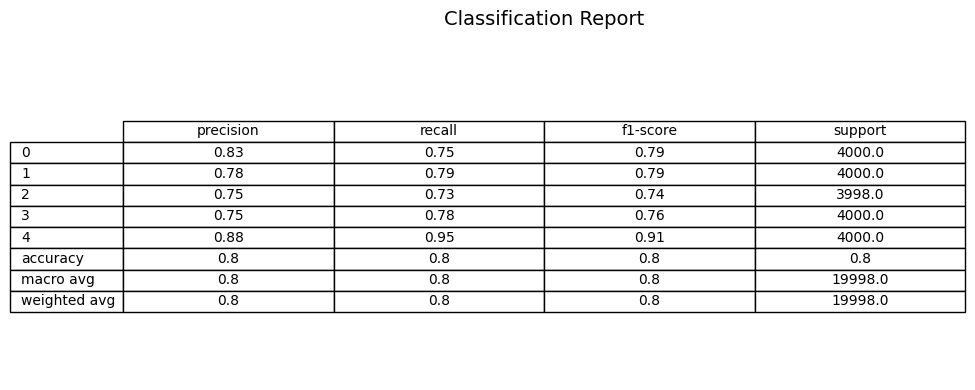

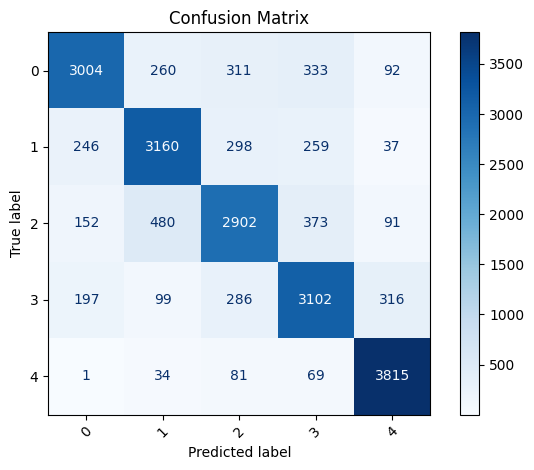


 Edge Case Performance:
Accuracy: 0.4138413841384138
              precision    recall  f1-score   support

           0       0.31      0.38      0.34      3183
           1       0.37      0.37      0.37      6740
           2       0.54      0.27      0.36      6013
           3       0.35      0.68      0.46      2105
           4       0.69      0.77      0.73      1957

    accuracy                           0.41     19998
   macro avg       0.45      0.49      0.45     19998
weighted avg       0.44      0.41      0.41     19998



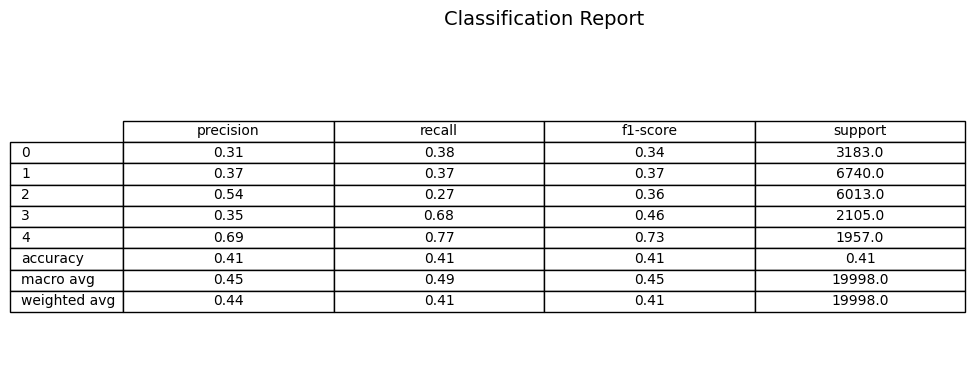

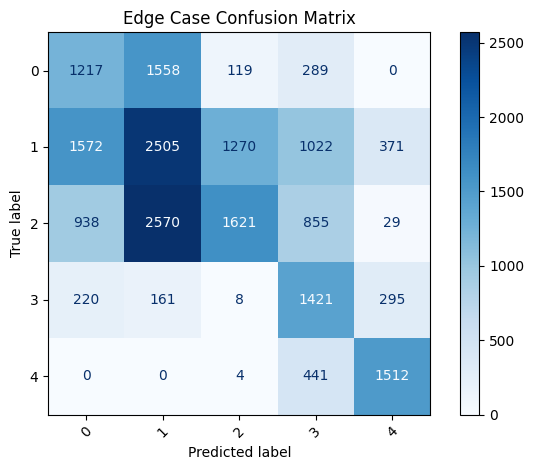

===============Medium===============
211960
999900
Epoch 1 - Training Loss: 0.9296
Epoch 2 - Training Loss: 0.6156
Epoch 3 - Training Loss: 0.4836
Epoch 4 - Training Loss: 0.4261
Epoch 5 - Training Loss: 0.3708

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      4000
           1       0.82      0.88      0.85      4000
           2       0.86      0.80      0.83      3998
           3       0.87      0.84      0.85      4000
           4       0.92      0.99      0.95      4000

    accuracy                           0.87     19998
   macro avg       0.87      0.87      0.87     19998
weighted avg       0.87      0.87      0.87     19998



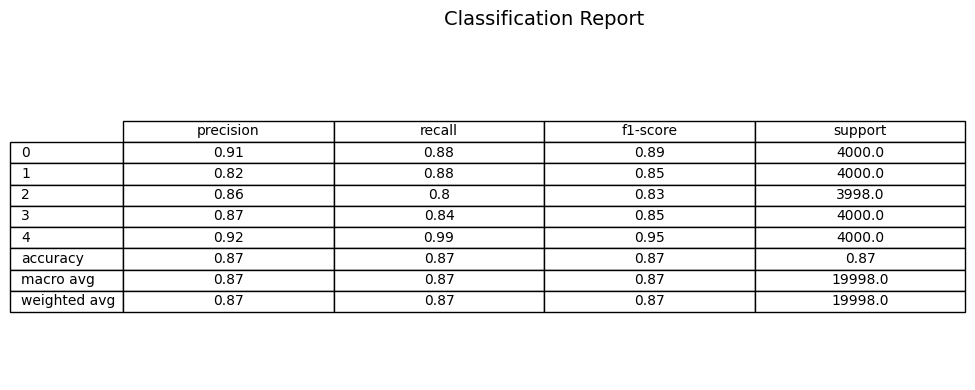

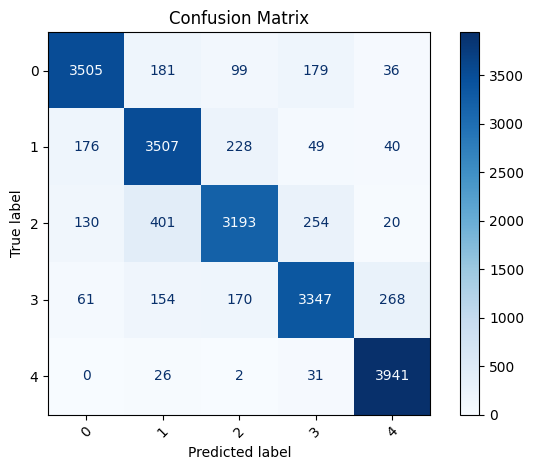


 Edge Case Performance:
Accuracy: 0.44304430443044307
              precision    recall  f1-score   support

           0       0.34      0.41      0.37      3183
           1       0.49      0.51      0.50      6740
           2       0.43      0.28      0.34      6013
           3       0.29      0.42      0.34      2105
           4       0.69      0.78      0.73      1957

    accuracy                           0.44     19998
   macro avg       0.45      0.48      0.46     19998
weighted avg       0.45      0.44      0.44     19998



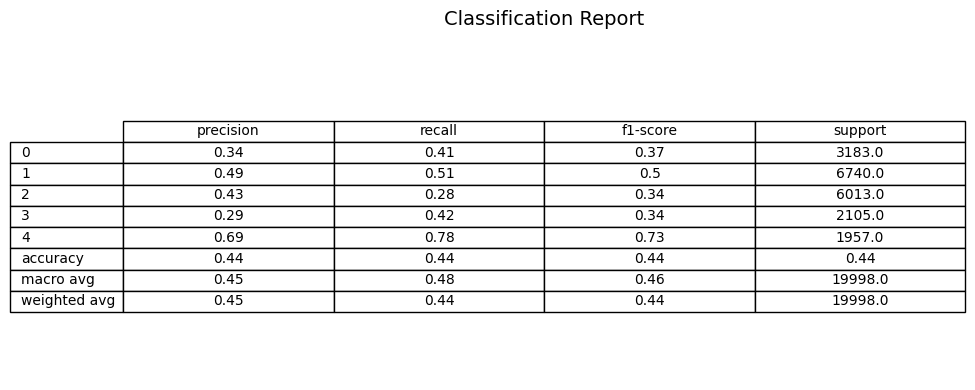

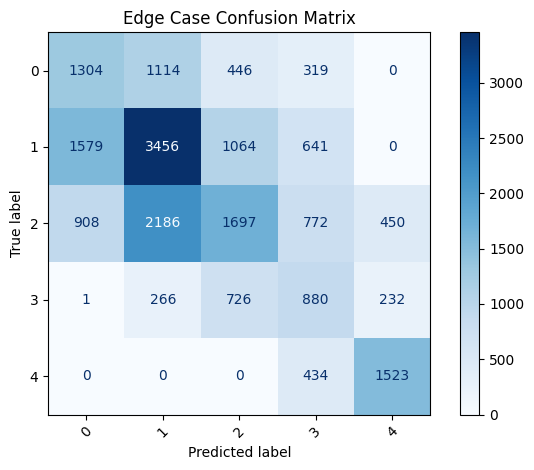

In [ ]:
small = ['outside_temp', 'outside_humidity', 'day_of_week']
medium = ['outside_temp', 'outside_humidity', 'day_of_week', 'light_lux', 'naturalLight']
big = ['outside_temp', 'outside_humidity', 'day_of_week', 'light_lux', 'naturalLight', 'co2eq_base', 'tvoc_base']
custom = ['rh_percent', 'co2eq_ppm', 'light_lux']


def evaluate_model_lstm(columns):
  # X_train, X_val, y_train, y_val, X_val_edge, y_val_edge = createBalanced(10, 'H1', columns)

  # Convert to PyTorch tensors
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.long)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.long)
  X_val_edge = torch.tensor(X_val_edge, dtype=torch.float32)
  y_val_edge = torch.tensor(y_val_edge, dtype=torch.long)

  train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
  val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
  edge_loader = DataLoader(TensorDataset(X_val_edge, y_val_edge), batch_size=64)


  class LSTMClassifier(nn.Module):
      def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=5):
          super().__init__()
          self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
          self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
          out, _ = self.lstm(x)
          out = out[:, -1, :]
          out = self.fc(out)
          return out

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Model
  model = LSTMClassifier(input_size=X_train.shape[2]).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(5):
      model.train()
      total_loss = 0
      for batch_X, batch_y in train_loader:
          batch_X, batch_y = batch_X.to(device), batch_y.to(device)
          optimizer.zero_grad()
          outputs = model(batch_X)
          loss = criterion(outputs, batch_y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")


  model.eval()
  all_preds, all_labels = [], []

  with torch.no_grad():
      for batch_X, batch_y in val_loader:
          batch_X = batch_X.to(device)
          outputs = model(batch_X)
          _, preds = torch.max(outputs, 1)
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(batch_y.numpy())


  print("\nClassification Report:\n", classification_report(all_labels, all_preds))
  report_dict = classification_report(all_labels, all_preds, output_dict=True)
  report_df = pd.DataFrame(report_dict).transpose().round(2)

  fig, ax = plt.subplots(figsize=(10, len(report_df) * 0.5))  # Adjust height based on rows

  ax.axis('off')
  ax.axis('tight')

  table = ax.table(cellText=report_df.values,
                   colLabels=report_df.columns,
                   rowLabels=report_df.index,
                   loc='center',
                   cellLoc='center')

  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table.scale(1.2, 1.2)

  plt.title("Classification Report", fontsize=14, pad=20)

  plt.tight_layout()
  plt.savefig("classification_reportLSTM.png", dpi=300, bbox_inches='tight')

  cm = confusion_matrix(all_labels, all_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
  disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.savefig("LSTMmatNormal.png")
  plt.show()

  # --- Edge Case Evaluation ---
  edge_preds, edge_labels = [], []

  with torch.no_grad():
      for batch_X, batch_y in edge_loader:
          batch_X = batch_X.to(device)
          outputs = model(batch_X)
          _, preds = torch.max(outputs, 1)
          edge_preds.extend(preds.cpu().numpy())
          edge_labels.extend(batch_y.numpy())

  print("\n Edge Case Performance:")
  print("Accuracy:", accuracy_score(edge_labels, edge_preds))
  print(classification_report(edge_labels, edge_preds))

  report_dict = classification_report(edge_labels, edge_preds, output_dict=True)
  report_df = pd.DataFrame(report_dict).transpose().round(2)

  fig, ax = plt.subplots(figsize=(10, len(report_df) * 0.5))  # Adjust height based on rows

  ax.axis('off')
  ax.axis('tight')

  table = ax.table(cellText=report_df.values,
                   colLabels=report_df.columns,
                   rowLabels=report_df.index,
                   loc='center',
                   cellLoc='center')

  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table.scale(1.2, 1.2)

  plt.title("Classification Report", fontsize=14, pad=20)

  plt.tight_layout()
  plt.savefig("classification_report_edgeLSTM.png", dpi=300, bbox_inches='tight')


  cm = confusion_matrix(edge_labels, edge_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
  disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
  plt.title("Edge Case Confusion Matrix")
  plt.tight_layout()
  plt.savefig("LSTMmatEdge.png")
  plt.show()

print("===============Small===============")
evaluate_model_lstm(small)

print("===============Medium===============")
evaluate_model_lstm(medium)

211960
599940
211960
599940


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:11:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Epoch 1 - LSTM Loss: 1.6125
Epoch 2 - LSTM Loss: 1.6110
Epoch 3 - LSTM Loss: 1.6096
Epoch 4 - LSTM Loss: 1.6083
Epoch 5 - LSTM Loss: 1.6070
Normal Validation Set:
Stacked Model Accuracy: 0.9504950495049505

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      4000
           1       0.92      0.93      0.92      4000
           2       0.91      0.94      0.93      3998
           3       0.97      0.96      0.97      4000
           4       0.98      0.99      0.99      4000

    accuracy                           0.95     19998
   macro avg       0.95      0.95      0.95     19998
weighted avg       0.95      0.95      0.95     19998



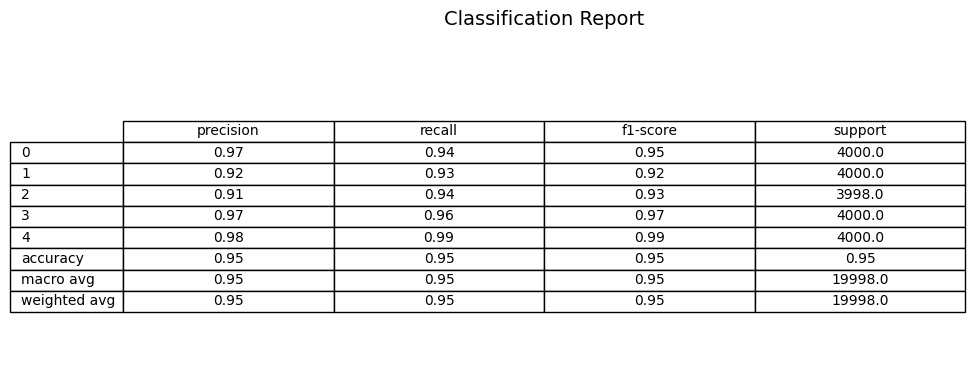

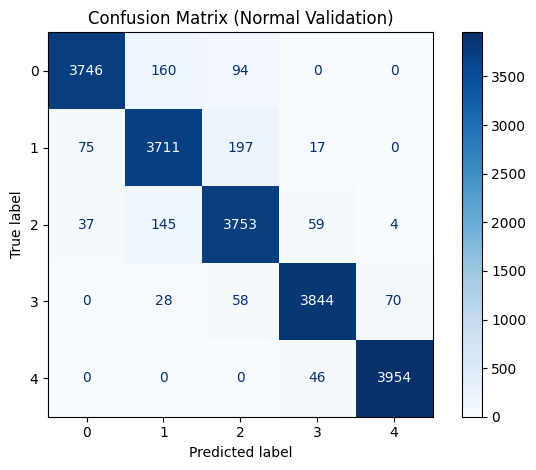

Edge Case Validation Set:
Stacked Model Accuracy: 0.9717971797179717

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      3183
           1       0.97      0.97      0.97      6740
           2       0.97      0.97      0.97      6013
           3       0.99      0.99      0.99      2105
           4       0.99      1.00      0.99      1957

    accuracy                           0.97     19998
   macro avg       0.98      0.98      0.98     19998
weighted avg       0.97      0.97      0.97     19998



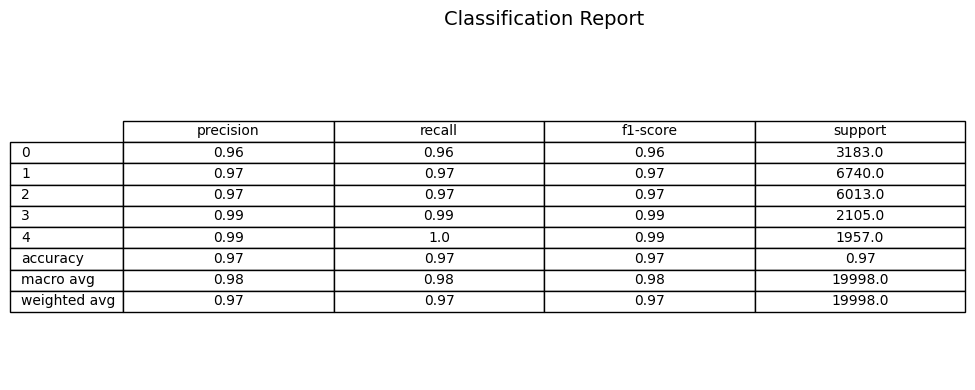

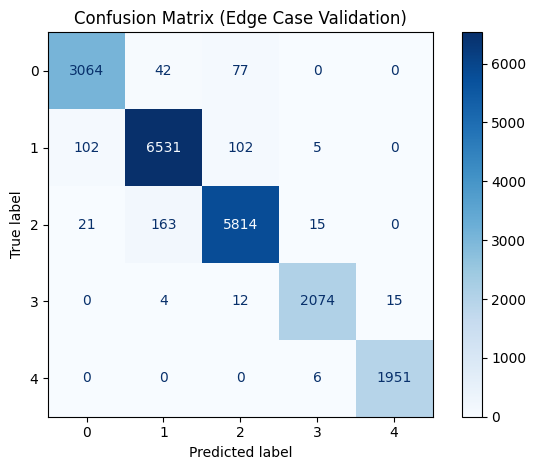


✅ Models saved successfully:
- XGBoost: xgb_model.json
- LSTM (PyTorch): lstm_model.pth
- Meta model (GradientBoosting): meta_model.pkl


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch

def stack_models(xgb_columns, lstm_columns):
    X_train_xgb, X_val_xgb, y_train, y_val, X_val_xgb_edge, y_val_xgb_edge = createBalanced(10, 'H1', xgb_columns)
    X_train_lstm, X_val_lstm, _, _, X_val_lstm_edge, y_val_lstm_edge = createBalanced(10, 'H1', lstm_columns)

    # Flatten XGBoost input
    X_train_xgb_flat = X_train_xgb.reshape(X_train_xgb.shape[0], -1)
    X_val_xgb_flat = X_val_xgb.reshape(X_val_xgb.shape[0], -1)
    X_val_xgb_edge_flat = X_val_xgb_edge.reshape(X_val_xgb_edge.shape[0], -1)

    ### ========== Train XGBoost ==========
    model_xgb = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=5,
        eval_metric="mlogloss",
        device="cuda"
    )
    model_xgb.fit(X_train_xgb_flat, y_train)
    xgb_val_probs = model_xgb.predict_proba(X_val_xgb_flat)
    xgb_val_edge_probs = model_xgb.predict_proba(X_val_xgb_edge_flat)

    ### ========== Train LSTM ==========
    class LSTMClassifier(nn.Module):
        def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=5):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = out[:, -1, :]
            return self.fc(out)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_lstm = LSTMClassifier(input_size=X_train_lstm.shape[2]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

    # Convert to tensors
    X_train_lstm_t = torch.tensor(X_train_lstm, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_lstm_t = torch.tensor(X_val_lstm, dtype=torch.float32).to(device)
    X_val_lstm_edge_t = torch.tensor(X_val_lstm_edge, dtype=torch.float32).to(device)

    # Train loop
    model_lstm.train()
    for epoch in range(5):
        optimizer.zero_grad()
        output = model_lstm(X_train_lstm_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1} - LSTM Loss: {loss.item():.4f}")

    # Get LSTM validation predictions
    model_lstm.eval()
    with torch.no_grad():
        logits = model_lstm(X_val_lstm_t)
        lstm_val_probs = F.softmax(logits, dim=1).cpu().numpy()

        edge_logits = model_lstm(X_val_lstm_edge_t)
        edge_lstm_val_probs = F.softmax(edge_logits, dim=1).cpu().numpy()


    meta_features = np.hstack([xgb_val_probs, lstm_val_probs])
    meta_features_edge = np.hstack([xgb_val_edge_probs, edge_lstm_val_probs])

    y_meta = np.concatenate([y_val, y_val_xgb_edge])

    X_meta_all = np.vstack([meta_features, meta_features_edge])

    X_meta_train, X_meta_holdout, y_meta_train, y_meta_holdout = train_test_split(
        X_meta_all, y_meta, test_size=0.3, stratify=y_meta, random_state=42
    )

    meta_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.9, random_state=42)

    meta_model.fit(X_meta_train, y_meta_train)

    final_preds_normal = meta_model.predict(meta_features)
    print("Normal Validation Set:")
    print("Stacked Model Accuracy:", accuracy_score(y_val, final_preds_normal))
    print("\nClassification Report:\n", classification_report(y_val, final_preds_normal))


    report_dict = classification_report(y_val, final_preds_normal, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().round(2)

    fig, ax = plt.subplots(figsize=(10, len(report_df) * 0.5))

    ax.axis('off')
    ax.axis('tight')

    table = ax.table(cellText=report_df.values,
                     colLabels=report_df.columns,
                     rowLabels=report_df.index,
                     loc='center',
                     cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title("Classification Report", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig("classification_reportENSAMBLENORMAL.png", dpi=300, bbox_inches='tight')

    cm = confusion_matrix(y_val, final_preds_normal)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4]).plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Normal Validation)")
    plt.tight_layout()
    plt.savefig("ensambleMatNormal.png")
    plt.show()

    final_preds_edge = meta_model.predict(meta_features_edge)
    print("Edge Case Validation Set:")
    print("Stacked Model Accuracy:", accuracy_score(y_val_xgb_edge, final_preds_edge))
    print("\nClassification Report:\n", classification_report(y_val_xgb_edge, final_preds_edge))


    report_dict = classification_report(y_val_xgb_edge, final_preds_edge, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().round(2)

    fig, ax = plt.subplots(figsize=(10, len(report_df) * 0.5))

    ax.axis('off')
    ax.axis('tight')

    table = ax.table(cellText=report_df.values,
                     colLabels=report_df.columns,
                     rowLabels=report_df.index,
                     loc='center',
                     cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.title("Classification Report", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig("classification_reportENSAMBLEEDG.png", dpi=300, bbox_inches='tight')



    cm = confusion_matrix(y_val_xgb_edge, final_preds_edge)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4]).plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Edge Case Validation)")
    plt.tight_layout()
    plt.savefig("ensambleMatEdge.png")
    plt.show()

    model_xgb.save_model("xgb_model.json")

    torch.save(model_lstm.state_dict(), "lstm_model.pth")

    import joblib
    joblib.dump(meta_model, "meta_model.pkl")


    print("\n Models saved successfully:")
    print("- XGBoost: xgb_model.json")
    print("- LSTM (PyTorch): lstm_model.pth")
    print("- Meta model (GradientBoosting): meta_model.pkl")
    return model_xgb, model_lstm, meta_model

x, l, m = stack_models(['day_of_week', 'outside_humidity', 'outside_temp'], ['rh_percent', 'co2eq_ppm', 'light_lux'])



211960
1399860
Final image shape: (99990, 10, 7, 7)


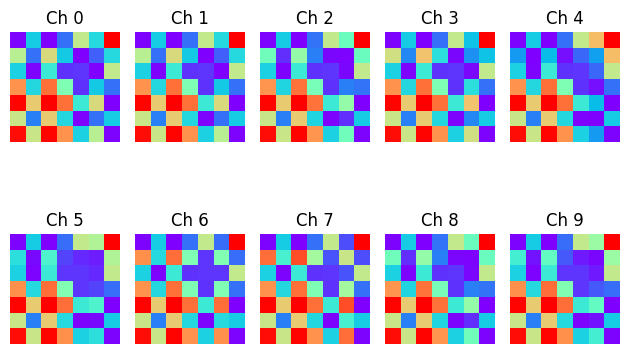

In [ ]:
# Converting chunks of data into images for VGG

from pyts.image import GramianAngularField
from sklearn.preprocessing import StandardScaler

useful_columns_vgg = ['co2eq_base', 'tvoc_ppb', 'naturalLight', 'light_lux', 'day_of_week', 'temp_c', 'outside_humidity']
X_vgg, y_vgg, X_vgg_edge, y_vgg_edge = createBalanced(10, 'H1', useful_columns_vgg, 20000, False)

gaf = GramianAngularField(method='summation')

X_images = []

for chunk in X_vgg:
    img_channels = []
    for feature_seq in chunk:
        img = gaf.fit_transform(feature_seq.reshape(1, -1))
        img_channels.append(img[0])
    X_images.append(np.stack(img_channels, axis=0))

X_images = np.array(X_images)
y_images = np.array(y_vgg)

X_images_edge = []
for chunk in X_vgg_edge:
    img_channels = []
    for feature_seq in chunk:
        img = gaf.fit_transform(feature_seq.reshape(1, -1))
        img_channels.append(img[0])
    X_images_edge.append(np.stack(img_channels, axis=0))

X_images_edge = np.array(X_images_edge)
y_images_edge = np.array(y_vgg_edge)


print(f"Final image shape: {X_images.shape}")
img = X_images[0]

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i], cmap='rainbow', origin='lower')
    plt.title(f"Ch {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

np.save('gaf_images.npy', X_images)
np.save('values.npy', y_images)

np.save('gaf_images_edge.npy', X_images_edge)
np.save('values_edge.npy', y_images_edge)

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# images_loaded = np.load('gaf_images.npy')
# labels_loaded = np.load('values.npy')

# edge_images_loaded = np.load('gaf_images_edge.npy')
# edge_labels_loaded = np.load('values_edge.npy')

class TimeSeriesImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx])
        label = torch.tensor(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label


vgg_dataset = TimeSeriesImageDataset(images_loaded, labels_loaded, transform=transforms.Resize((244, 244)))

train_size = int(0.8 * len(vgg_dataset))
val_size = len(vgg_dataset) - train_size

train_dataset, val_dataset = random_split(vgg_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

edge_dataset = TimeSeriesImageDataset(edge_images_loaded, edge_labels_loaded, transform=transforms.Resize((244, 244)))
edge_loader = DataLoader(edge_dataset, batch_size=64, shuffle=False)

vgg = models.vgg16(pretrained=True)

# Replace first conv layer to accept 10 channels
old_weights = vgg.features[0].weight.data
new_conv = nn.Conv2d(in_channels=10, out_channels=64, kernel_size=3, padding=1)

with torch.no_grad():
    new_conv.weight[:, :3] = old_weights  # Copy RGB weights
    new_conv.weight[:, 3:] = torch.randn((64, 7, 3, 3)) * 0.01  # Init rest
    new_conv.bias = vgg.features[0].bias

vgg.features[0] = new_conv

# Replace classifier output layer
vgg.classifier[6] = nn.Linear(4096, 5)
vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

def evaluate(model, loader, title="Validation"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, digits=4)

    print(f"\n=== {title} Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"\nClassification Report:\n{cr}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"\nEpoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")

    evaluate(model, val_loader, title="Validation")
    evaluate(model, edge_loader, title="Edge Case")

train_model(vgg, train_loader, val_loader, epochs=10)
torch.save(vgg, 'vgg_full_model.pth')
from google.colab import files
files.download('vgg_full_model.pth')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s]



Epoch 1 - Training Loss: 0.9078

Epoch 2 - Training Loss: 0.4279

Epoch 3 - Training Loss: 0.2692

Epoch 4 - Training Loss: 0.1900

Epoch 5 - Training Loss: 0.1465

Epoch 6 - Training Loss: 0.1144

Epoch 7 - Training Loss: 0.0972

Epoch 8 - Training Loss: 0.0810

Epoch 9 - Training Loss: 0.0717


In [ ]:
# useful_columns = ['co2eq_base', 'tvoc_ppb', 'naturalLight', 'light_lux', 'day_of_week', 'temp_c', 'outside_humidity']
# X, y, X_edge, y_edge = createBalanced(10, "H1", useful_columns, 20000, False)
X = np.load("x.npy")
y = np.load("y.npy")
X_edge = np.load("x_edge.npy")
y_edge = np.load("y_edge.npy")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datasets.formatting.formatting as ds_formatting

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X.iloc[i:i+seq_len].values.flatten())
        ys.append(y.iloc[i+seq_len])
    return pd.DataFrame(xs), pd.Series(ys)

# Parameters
seq_len = 10
# useful_columns = ['co2eq_base', 'tvoc_ppb', 'naturalLight', 'light_lux', 'day_of_week', 'temp_c', 'outside_humidity']
# X, y, X_edge, y_edge = createBalanced(10, "H1", useful_columns, 20000, False)

# X_seq, y_seq = create_sequences(pd.DataFrame(X, columns=useful_columns), pd.Series(y), seq_len)
# X_seq_edge, y_seq_edge = create_sequences(pd.DataFrame(X_edge, columns=useful_columns), pd.Series(y_edge), seq_len)

X_seq, y_seq = X, y
X_seq_edge, y_seq_edge = X_edge, y_edge

# Flatten 3D arrays to 2D for text conversion
X_seq_flat = X_seq.reshape((X_seq.shape[0], -1))
X_edge_flat = X_edge.reshape((X_edge.shape[0], -1))


# Convert to DataFrames
seq_df = pd.DataFrame(X_seq_flat)
seq_df["number"] = y

seq_df_edge = pd.DataFrame(X_edge_flat)
seq_df_edge["number"] = y_edge

#Convert everything to text
def row_to_text(row):
    return ', '.join([f"{i}: {val}" for i, val in enumerate(row[:-1])])

seq_df["text"] = seq_df.apply(row_to_text, axis=1)
seq_df["label"] = seq_df["number"].astype(int)

seq_df_edge["text"] = seq_df_edge.apply(row_to_text, axis=1)
seq_df_edge["label"] = seq_df_edge["number"].astype(int)

train_df, val_df = train_test_split(seq_df[["text", "label"]], test_size=0.2, stratify=seq_df["label"], random_state=42)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True))
})

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

#Load model and freeze everything but the last transformer layer and the classsifier
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

for name, param in model.distilbert.named_parameters():
    if "transformer.layer.4" in name or "transformer.layer.5" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

def patched_arrow_array_to_numpy(self, pa_array):
    try:
        array = pa_array.to_numpy(zero_copy_only=False)
    except Exception:
        array = pa_array.to_pylist()
    return np.asarray(array)

# Apply the patch
ds_formatting._NumpyFormatter._arrow_array_to_numpy = patched_arrow_array_to_numpy
trainer.train()

metrics = trainer.evaluate()
print("Final Evaluation Metrics:", metrics)

predictions = trainer.predict(tokenized_datasets["validation"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# --- EDGE CASE EVALUATION ---

# Tokenize edge data
edge_dataset = Dataset.from_pandas(seq_df_edge[["text", "label"]].reset_index(drop=True))
tokenized_edge_dataset = edge_dataset.map(tokenize_function, batched=True)
tokenized_edge_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Predict
edge_predictions = trainer.predict(tokenized_edge_dataset)
y_edge_true = edge_predictions.label_ids
y_edge_pred = edge_predictions.predictions.argmax(axis=1)

# Confusion matrix
edge_cm = confusion_matrix(y_edge_true, y_edge_pred)
edge_disp = ConfusionMatrixDisplay(confusion_matrix=edge_cm, display_labels=[0, 1, 2, 3, 4])
edge_disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - Edge Cases")
plt.show()

# Metrics
print("Edge Case Classification Report:")
print(classification_report(y_edge_true, y_edge_pred, digits=4))



NameError: name 'X' is not defined

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import xgboost as xgb
import joblib
from sklearn.preprocessing import StandardScaler
import time
import random

xgb_model = xgb.XGBClassifier()
xgb_model.load_model("xgb_model(1).json")

class LSTMClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=5):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

lstm_model = LSTMClassifier(input_size=3)
lstm_model.load_state_dict(torch.load("lstm_model(1).pth", map_location="cpu"))
lstm_model.eval()

meta_model = joblib.load("meta_model(2).pkl")
device = "cuda"
lstm_model.to(device)
lstm_model.eval()

home = "H1"
num_samples = 2000
xgb_columns = ['day_of_week', 'outside_humidity', 'outside_temp']
lstm_columns = ['rh_percent', 'co2eq_ppm', 'light_lux']

h1_df = df[df['home'] == home].copy()

def sample_every_n(df, target_samples):
    total_rows = len(df)
    step = max(1, total_rows // target_samples)
    return df.iloc[::step].head(target_samples)

balanced_dfs = []
for class_label in h1_df['number'].unique():
    class_df = h1_df[h1_df['number'] == class_label]
    sampled_df = sample_every_n(class_df, num_samples)
    balanced_dfs.append(sampled_df)

balanced_df = pd.concat(balanced_dfs)
balanced_df = balanced_df.sort_index().reset_index(drop=True)

X_xgb = balanced_df[xgb_columns]
X_lstm = balanced_df[lstm_columns]
y = balanced_df['number']

scaler = StandardScaler()
X_xgb_scaled = pd.DataFrame(scaler.fit_transform(X_xgb), columns=xgb_columns)
X_lstm_scaled = pd.DataFrame(scaler.fit_transform(X_lstm), columns=lstm_columns)


def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

seq_len = 10
X_seq_xgb, y_seq = create_sequences(X_xgb_scaled.values, y.values, seq_len)
X_seq_lstm, _ = create_sequences(X_lstm_scaled.values, y.values, seq_len)

X_xgb_orig = balanced_df[xgb_columns].to_numpy()  # or however you get original
X_seq_xgb_orig, _ = create_sequences(X_xgb_orig, y.values, seq_len=seq_len)

X_lstm_orig = balanced_df[lstm_columns].to_numpy()
X_seq_lstm_orig, _ = create_sequences(X_lstm_orig, y.values, seq_len=seq_len)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_windows = len(X_seq_xgb)
indices = random.sample(range(total_windows), 10)  # random unique 10 indices
last_number = 0


for idx in indices:
    print(f"Window {idx+1}: Measuring data ..........")
    time.sleep(2)

    rh_percent = X_seq_lstm_orig[idx][-1, 0]
    co2eq = X_seq_lstm_orig[idx][-1, 1]
    light_lux = X_seq_lstm_orig[idx][-1, 2]

    print(f"Data: Humidity: {rh_percent:.2f}, CO2: {co2eq:.2f}, Light: {light_lux:.2f}")
    time.sleep(2)

    day_of_week = X_seq_xgb_orig[idx][-1, 0]
    outside_humidity = X_seq_xgb_orig[idx][-1, 1]
    outside_temp = X_seq_xgb_orig[idx][-1, 2]

    if(day_of_week == 1.0):
      day = "Week day"
    else:
      day = "Week end"

    print(f"Added data: day: {day}, Outside humidity: {outside_humidity:.2f}, Outside temperature: {outside_temp:.2f}")
    time.sleep(2)

    xgb_input = X_seq_xgb[idx].reshape(1, -1)
    lstm_input = torch.tensor(X_seq_lstm[idx], dtype=torch.float32).unsqueeze(0).to(device)

    xgb_probs = xgb_model.predict_proba(xgb_input)

    lstm_model.eval()
    with torch.no_grad():
        lstm_logits = lstm_model(lstm_input)
        lstm_probs = F.softmax(lstm_logits, dim=1).cpu().numpy()

    meta_input = np.hstack([xgb_probs, lstm_probs])
    final_pred = meta_model.predict(meta_input)[0]

    print(f"Occupation level: {final_pred}")
    if(final_pred == 0):
      print("There are no more people, turn off lights!")
    else:
      if(last_number == 0 and final_pred != 0):
        print("People arrived, open blinds!")
      else:
        if(last_number > final_pred):
          print("Some people left, adjust AC!")

    last_number = final_pred
    time.sleep(4)
    print("-" * 40)


Window 6690: Measuring data ..........
Data: Humidity: 24.00, CO2: 400.00, Light: 28.00
Added data: day: Week end, Outside humidity: 100.00, Outside temperature: -2.50
Occupation level: 0
There are no more people, turn off lights!
----------------------------------------
Window 45: Measuring data ..........
Data: Humidity: 21.10, CO2: 400.00, Light: 0.00
Added data: day: Week day, Outside humidity: 95.20, Outside temperature: -3.60
Occupation level: 0
There are no more people, turn off lights!
----------------------------------------
Window 9862: Measuring data ..........
Data: Humidity: 16.90, CO2: 400.00, Light: 617.00
Added data: day: Week day, Outside humidity: 50.00, Outside temperature: 0.70
Occupation level: 1
People arrived, open blinds!
----------------------------------------
Window 7087: Measuring data ..........
Data: Humidity: 47.70, CO2: 400.00, Light: 14.00
Added data: day: Week end, Outside humidity: 54.28, Outside temperature: -1.60
Occupation level: 1
----------------

KeyboardInterrupt: 